# Interpolation Notebook
This notebook is used to find the best interpolation method for creating signals with uniform timesteps for our recorded dataset.

## Imports

In [1]:
import os
import numpy as np

import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')

Only choose bagfiles which were recorded using the 'wobble'

In [3]:
bag_files = os.listdir('Dataset')
readers = []
for f in bag_files:
    if f.endswith('_wobble.bag'):
        readers.append(bagreader('Dataset/'+ f))

[INFO]  Data folder Dataset/2021-11-26-20-01-52_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2021-11-26-20-05-14_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2021-11-26-20-14-48_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-18-38_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-34-38_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-48-10_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-18-02-22_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-20-15-23-37_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-20-15-38-51_wobble already exists. Not creating.


Show all possible topics. We will prob only be interested in */imu/imu* or */tum/lmt/joints_goal*

## Read Raw Data

In [4]:
imu = readers[0].message_by_topic('/imu/imu')
df_imu = pd.read_csv(imu)

joints_goal = readers[0].message_by_topic('/tum/lmt/joints_goal')
df_joints_goal = pd.read_csv(joints_goal)
joints_status = readers[0].message_by_topic('/tum/lmt/joints_status')
df_joints_status   = pd.read_csv(joints_status)

## Interpolation Experiments
We interpolate the raw data using different interpolation methods to see which one gives us the best approximation of the original signal.
__Mean Absolute Error__ and __Mean Squared Error__ are used as comparison metrics. <br>

We first visualize the time deltas between the recording steps to see why an interpolation is necessary. Then a comparison of the different interpolation methods is being done.

Method: "linear". Absolute error: 18.0252740728238. Squared error: 0.26342965630767623.
Method: "slinear". Absolute error: 18.025274072823805. Squared error: 0.26342965630767623.
Method: "quadratic". Absolute error: 26.972269275662775. Squared error: 0.9657835655679275.
Method: "cubic". Absolute error: 28.345629773919068. Squared error: 0.9696781383255657.
Method: "nearest". Absolute error: 24.414885817773673. Squared error: 0.4152473790290205.
Method: "previous". Absolute error: 51.59470621682548. Squared error: 1.5937254647119423.
Minimum Absolute error: 18.0252740728238. Method: "linear"
Minimum Squared error: 0.26342965630767623. Method: "linear"


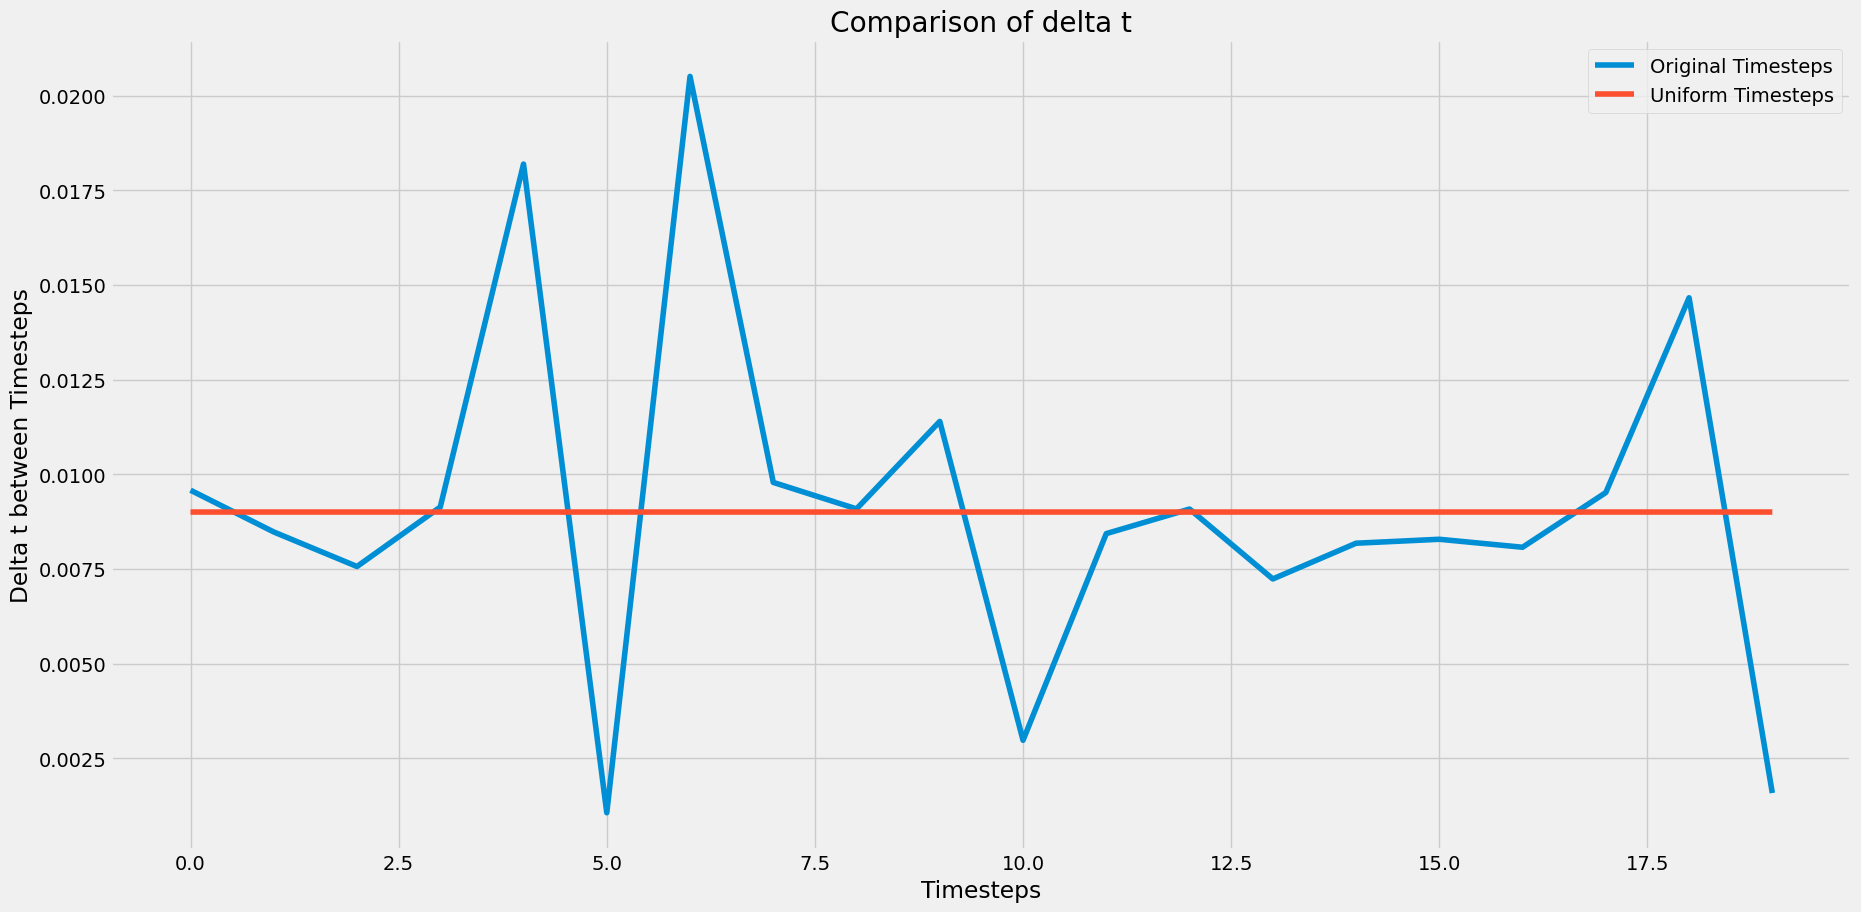

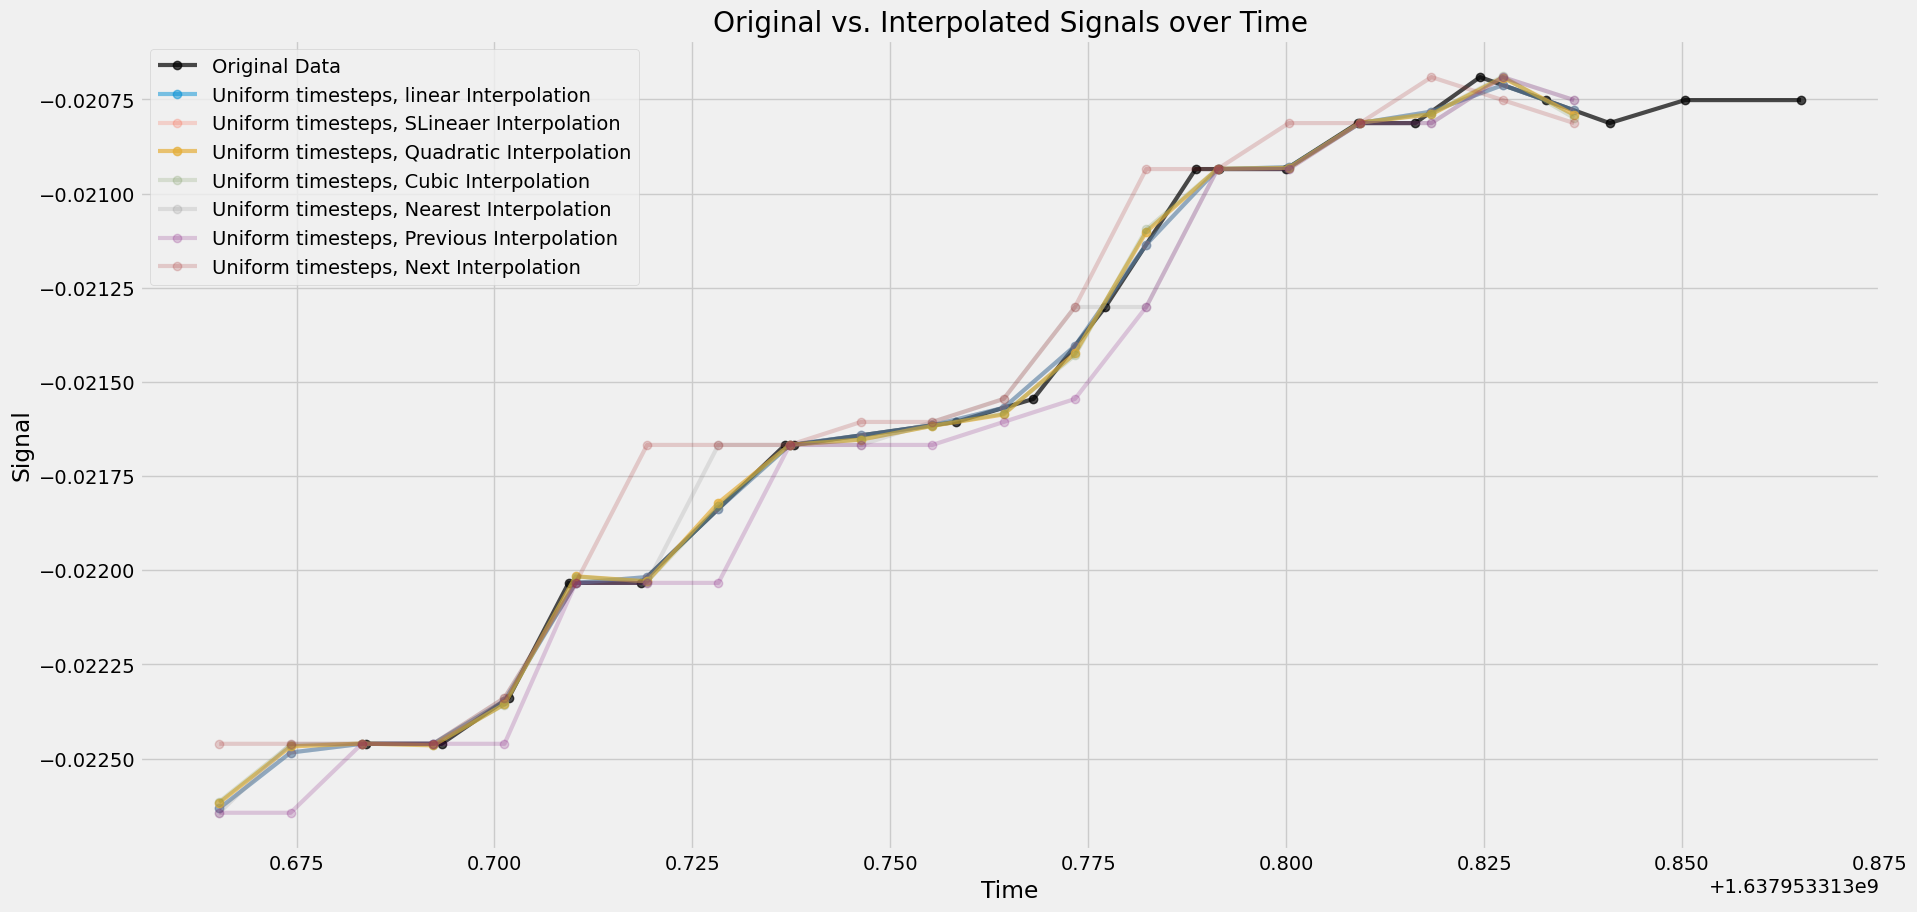

In [5]:
from scipy.interpolate import interp1d
# Extract original data from dataframe
orig_timesteps = df_imu['Time']
orig_data = df_imu['orientation.x']

# Create interpolation function based on data
interp_f = interp1d(orig_timesteps, orig_data, kind='linear')
interp_f_slinear = interp1d(orig_timesteps, orig_data, kind='slinear')
interp_f_quadratic = interp1d(orig_timesteps, orig_data, kind='quadratic')
interp_f_cubic = interp1d(orig_timesteps, orig_data, kind='cubic')
interp_f_nearest = interp1d(orig_timesteps, orig_data, kind='nearest')
interp_f_previous = interp1d(orig_timesteps, orig_data, kind='previous')
interp_f_next = interp1d(orig_timesteps, orig_data, kind='next')

# Set up new linear timeline with uniform timesteps
n_samples = len(orig_timesteps)
start = orig_timesteps.iloc[0]
end = orig_timesteps.iloc[-1]

uniform_t = np.linspace(start, end, num = n_samples)

# Interpolate signals to have uniform timesteps
uniform_data = interp_f(uniform_t)
uniform_data_slinear = interp_f_slinear(uniform_t)
uniform_data_quadratic = interp_f_quadratic(uniform_t)
uniform_data_cubic = interp_f_cubic(uniform_t)
uniform_data_nearest = interp_f_nearest(uniform_t)
uniform_data_previous = interp_f_previous(uniform_t)
uniform_data_next = interp_f_next(uniform_t)

# Visualize time deltas between recordings.
p_s = 100 # signal start
p_e = 120 # signal end
plt.figure()
plt.plot(np.diff(orig_timesteps)[p_s:p_e], label='Original Timesteps')
plt.plot(np.diff(uniform_t)[p_s:p_e], label='Uniform Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Delta t between Timesteps')
plt.title('Comparison of delta t')
plt.legend()


plt.figure()
plt.plot(orig_timesteps[p_s:p_e], orig_data[p_s:p_e], marker='o', label= 'Original Data', alpha = .7, linewidth = 3, color = 'black')
plt.plot(uniform_t[p_s:p_e], uniform_data[p_s:p_e], marker='o', label = 'Uniform timesteps, linear Interpolation', alpha = .5, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_slinear[p_s:p_e], marker='o', label = 'Uniform timesteps, SLineaer Interpolation', alpha = .2, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_quadratic[p_s:p_e], marker='o', label = 'Uniform timesteps, Quadratic Interpolation', alpha = .7, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_cubic[p_s:p_e], marker='o', label = 'Uniform timesteps, Cubic Interpolation', alpha = .2, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_nearest[p_s:p_e], marker='o', label = 'Uniform timesteps, Nearest Interpolation', alpha = .2, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_previous[p_s:p_e], marker='o', label = 'Uniform timesteps, Previous Interpolation', alpha = .2, linewidth = 3)
plt.plot(uniform_t[p_s:p_e], uniform_data_next[p_s:p_e], marker='o', label = 'Uniform timesteps, Next Interpolation', alpha = .2, linewidth = 3, color = 'brown')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Original vs. Interpolated Signals over Time')
plt.legend()

errors = []
def calc_error(uniform_t, uniform_d, orig_t, orig_data, method_name = ''):
    interp_f = interp1d(uniform_t, uniform_d)
    back_to_orig_d = interp_f(orig_t)

    error = orig_data - back_to_orig_d
    abs_error = np.sum(np.abs(error))
    squared_error = np.sum(np.square(error))

    print(f'Method: "{method_name}". Absolute error: {abs_error}. Squared error: {squared_error}.')
    return [abs_error, squared_error, method_name]

errors.append(calc_error(uniform_t, uniform_data, orig_timesteps, orig_data, 'linear'))
errors.append(calc_error(uniform_t, uniform_data_slinear, orig_timesteps, orig_data, 'slinear'))
errors.append(calc_error(uniform_t, uniform_data_quadratic, orig_timesteps, orig_data, 'quadratic'))
errors.append(calc_error(uniform_t, uniform_data_cubic, orig_timesteps, orig_data, 'cubic'))
errors.append(calc_error(uniform_t, uniform_data_nearest, orig_timesteps, orig_data, 'nearest'))
errors.append(calc_error(uniform_t, uniform_data_previous, orig_timesteps, orig_data, 'previous'))

abs_errors = [a[0] for a in errors]
square_errors = [a[1] for a in errors]
print(f'Minimum Absolute error: {np.min(abs_errors)}. Method: "{errors[np.argmin(abs_errors)][2]}"')
print(f'Minimum Squared error: {np.min(square_errors)}. Method: "{errors[np.argmin(square_errors)][2]}"')

### Results:
The Interpolation method with the smallest absolute and squared error compared to the original input signal is **linear** interpolation. it will therefore be used as the interpolation method.

## **Interpolation Function**
Implementation of Interpolation function for the dataframes. ***uniform_t*** can be handed over to the function, which enables uniform interpolation of all dataframes with desired ***sample_rate***.

In [6]:
from scipy.interpolate import interp1d
import numpy as np

def uniform_time_interpolation(dataframe, params = ['orientation.x'], uniform_t = None, start = None, end = None, n_samples = None, sample_rate = None):
    """
    Interpolates specific signals from a pandas dataframe and returns them in a dictionary. 
    If the uniform_t signal from another interpolation is given, this function creates interpolated signals at the same timesteps.

    param dataframe: Input pandas dataframe generated from rosbag file
    param params: Desired signals to be interpolated
    param uniform_t: desired timesteps to be interpolated to. Overrides start, end n_samples and sample_rate.
    param start: desired start time
    param end: desired end time
    param n_samples: desired umber of samples between start and end
    param sample_rate: Desired sample rate. Overrides n_samples
    
    return uniform_t: New time vector with uniform timesteps. Or uniform_t given to the function.
    return  uniform_signals: Dictionary of interpolated signals with the params as keys
    """
    interp_fs = dict()
    uniform_signals = dict()

    # Load original Timesteps
    orig_t = dataframe['Time']
    duration = orig_t.iloc[-1] - orig_t.iloc[0]

    orig_n = len(dataframe['Time'])
    orig_sr = orig_n / (duration)

    # Create interpolation functions for all parameters
    for p in params:
        interp_fs[p] = interp1d(orig_t, dataframe[p], fill_value='extrapolate')

    # Create sample numbers, beginning and end points of interpolation, if they were not given
    if not n_samples:        
        n_samples = len(orig_t)#len(orig_timesteps)
    if not start:
        start = orig_t.iloc[0]
    if not end:
        end = orig_t.iloc[-1]

    if sample_rate:
        n_duration = end - start
        n_samples = np.floor(sample_rate*n_duration).astype(int)
        end = n_samples / sample_rate + start

    # Create uniform Timesteps
    if uniform_t is None:
        uniform_t = np.linspace(start, end, num = n_samples)

    # Signal Interpolation    
    for p in params:
        uniform_signals[p] = interp_fs[p](uniform_t)

    # Print some information about the process
    sample_rate = len(uniform_t)/(uniform_t[-1] - uniform_t[0])
    n_samples = len(uniform_t)
    print(f'Converted Signals: {params}.')
    print(f'\tBefore: Duration: {duration:.3f}s. Avg Sample Rate: {orig_sr:.3f}/s. Number of samples: {orig_n}.')
    print(f'\tAfter: Duration: {end - start :.3f}s. Avg Sample Rate: {sample_rate:.3f}/s. Number of samples: {n_samples}. \n')

    return uniform_t, uniform_signals

In [7]:
t, sigs = uniform_time_interpolation(df_imu, params = ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w'], sample_rate = 120)
_, sigs_joints = uniform_time_interpolation(df_joints_goal, params = ['position_0', 'position_1'], uniform_t = t);

Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w'].
	Before: Duration: 181.698s. Avg Sample Rate: 111.036/s. Number of samples: 20175.
	After: Duration: 181.692s. Avg Sample Rate: 120.000/s. Number of samples: 21803. 

Converted Signals: ['position_0', 'position_1'].
	Before: Duration: 181.744s. Avg Sample Rate: 111.828/s. Number of samples: 20324.
	After: Duration: 181.744s. Avg Sample Rate: 120.000/s. Number of samples: 21803. 



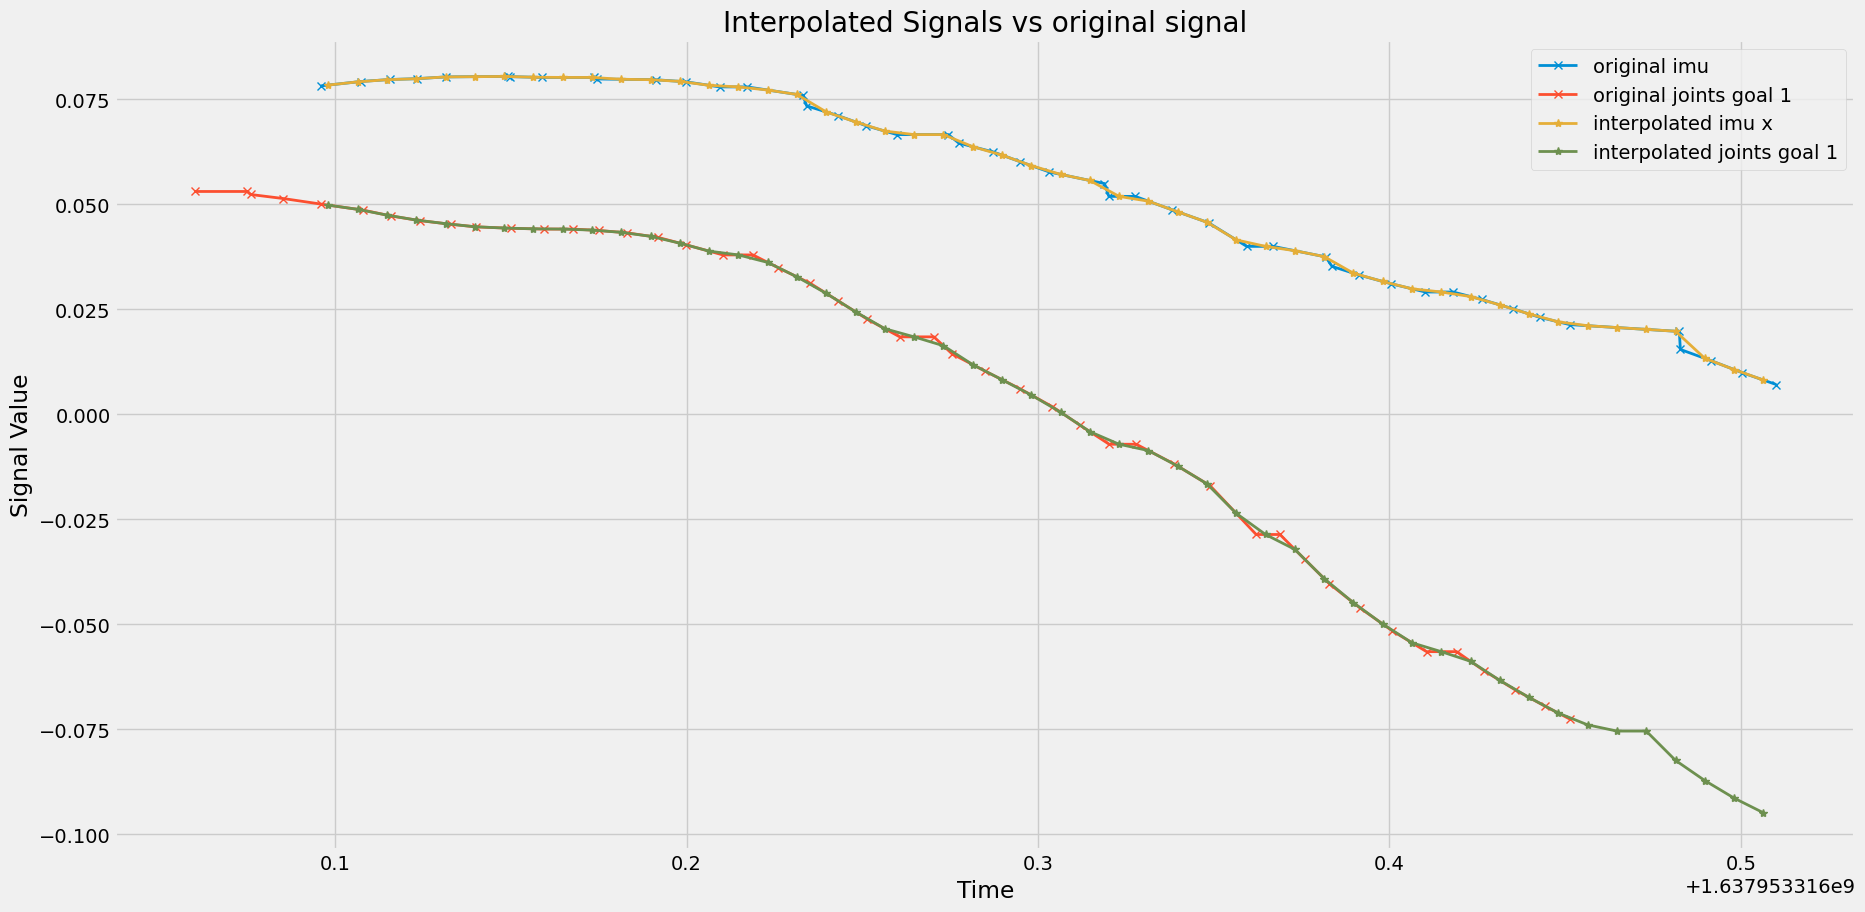

In [18]:
a = 400
e = 450
a2 = 367
e2 =413
plt.plot(df_imu['Time'][a2:e2], df_imu['orientation.x'][a2:e2], linewidth=2, marker='x', label = 'original imu')
plt.plot(df_joints_goal['Time'][a2:e2], df_joints_goal['position_0'][a2:e2], linewidth=2, marker='x', label = 'original joints goal 1')
plt.plot(t[a:e], sigs['orientation.x'][a:e], linewidth=2, marker='*', label='interpolated imu x')
plt.plot(t[a:e], sigs_joints['position_0'][a:e], linewidth=2, marker='*', label = 'interpolated joints goal 1')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.title('Interpolated Signals vs original signal');

## Convert and Save
All datasets are interpolated and saved.

Parameters to keep and interpolate:

In [10]:
imu_params = ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 
              'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 
              'linear_acceleration.y', 'linear_acceleration.z']
joints_goal_params = ['position_0', 'position_1']
joints_status_params = ['position_0', 'position_1']

In [11]:
import pickle

bag_files = os.listdir('Dataset')
bag_files
readers = []
for f in bag_files:
    if f.endswith('_wobble.bag'):
        readers.append([bagreader('Dataset/'+ f), f])


def convert_and_save(reader, sample_rate = 120, write = True, location = 'Dataset/Converted_120Hz/'):

    imu_params = ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 
              'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 
              'linear_acceleration.y', 'linear_acceleration.z']
    joints_goal_params = ['position_0', 'position_1']
    joints_status_params = ['position_0', 'position_1']

    imu = reader[0].message_by_topic('/imu/imu')
    df_imu = pd.read_csv(imu)

    joints_goal = reader[0].message_by_topic('/tum/lmt/joints_goal')
    df_joints_goal = pd.read_csv(joints_goal)
    joints_status = reader[0].message_by_topic('/tum/lmt/joints_status')
    df_joints_status   = pd.read_csv(joints_status)

    t, sigs_imu = uniform_time_interpolation(df_imu, params = imu_params, sample_rate = sample_rate)
    _, sigs_joints = uniform_time_interpolation(df_joints_goal, params = joints_goal_params, uniform_t = t)
    _, sigs_joints_status = uniform_time_interpolation(df_joints_status, params = joints_status_params, uniform_t = t)

    data_dict = {'Time': t, 
              **sigs_imu, 
              **sigs_joints,
              'position_0_status': sigs_joints_status['position_0'],
              'position_1_status': sigs_joints_status['position_1'],
              'sample_rate':sample_rate}

    if write:
        if not os.path.exists(location):
            os.makedirs(location)
        filename = location + reader[1][:-4] + f'_interpolated_{sample_rate}Hz.pickle'
        print(filename)
        with open(filename, 'wb') as handle:
            pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return data_dict

all_dicts_120 = []
for r in readers:
    all_dicts_120.append(convert_and_save(r, 120, write=True))
    
#all_dicts_10 = []
#for r in readers:
#    all_dicts_10.append(convert_and_save(r, 10, write=True, location='Dataset/Converted_10Hz/'))


[INFO]  Data folder Dataset/2022-01-20-15-23-37_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2021-11-26-20-01-52_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2021-11-26-20-05-14_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-20-15-38-51_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-18-38_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-18-02-22_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-34-38_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2022-01-13-17-48-10_wobble already exists. Not creating.
[INFO]  Data folder Dataset/2021-11-26-20-14-48_wobble already exists. Not creating.
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_a

In [12]:
with open(r'Dataset/Converted_120Hz/2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle', "rb") as input_file:
    e = pickle.load(input_file)

#with open(r'Dataset/Converted_10Hz/2021-11-26-20-14-48_wobble_interpolated_10Hz.pickle', "rb") as input_file:
#    e = pickle.load(input_file)

120


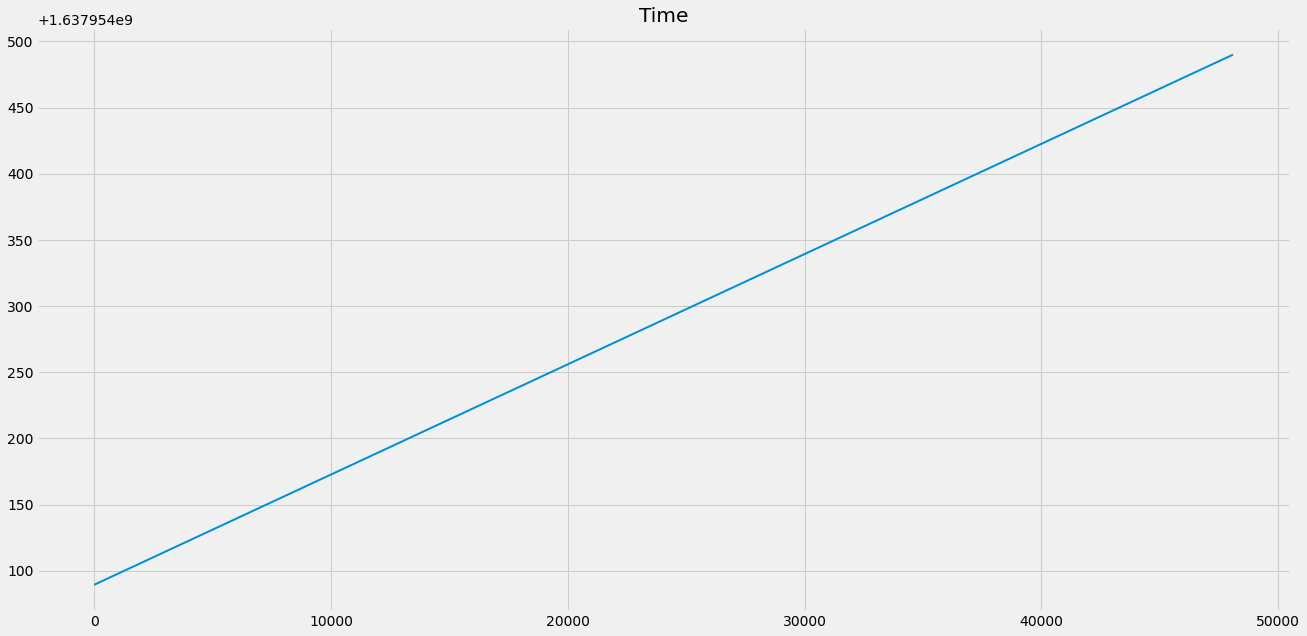

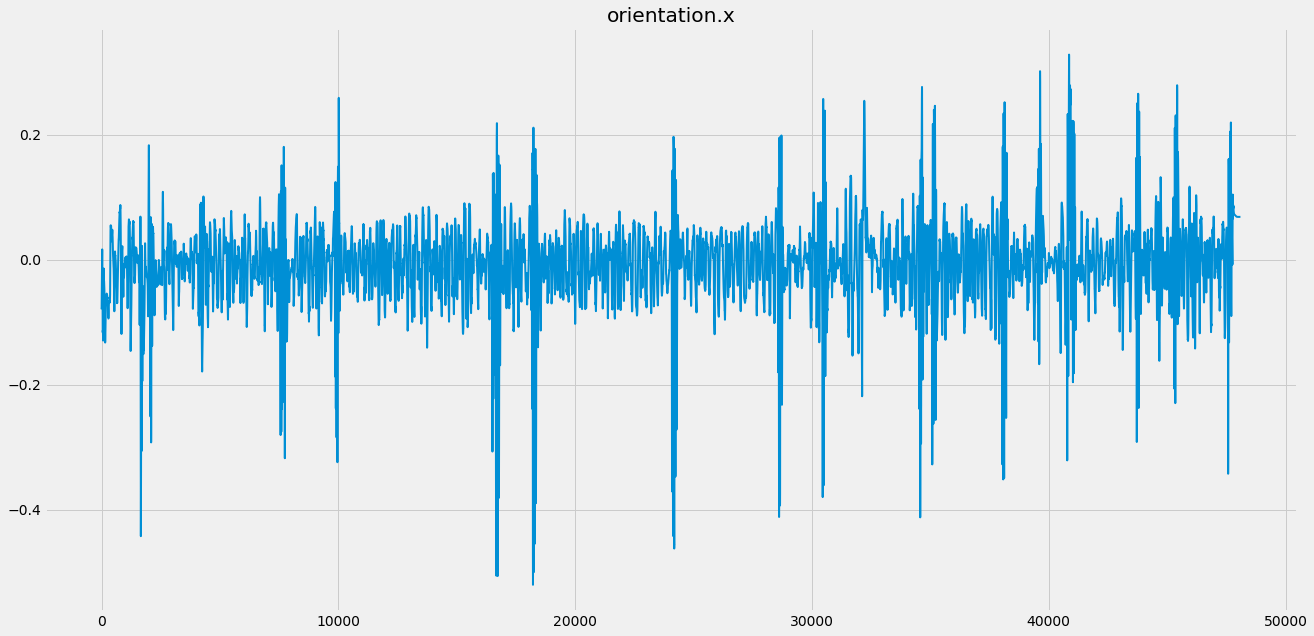

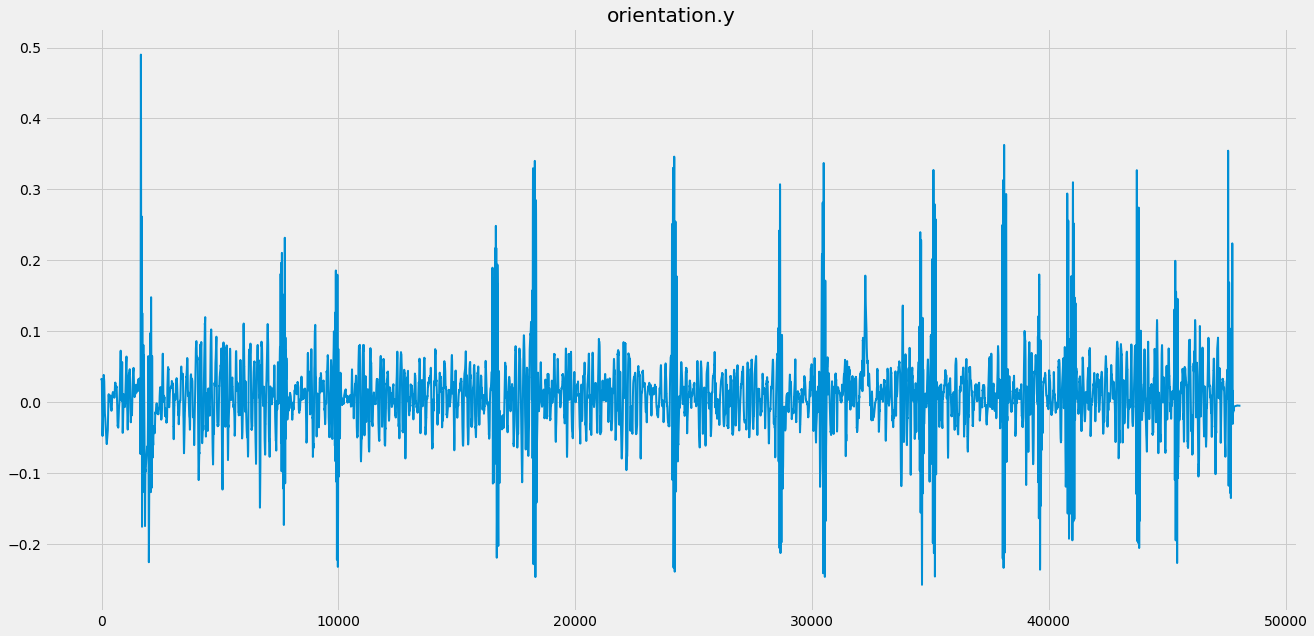

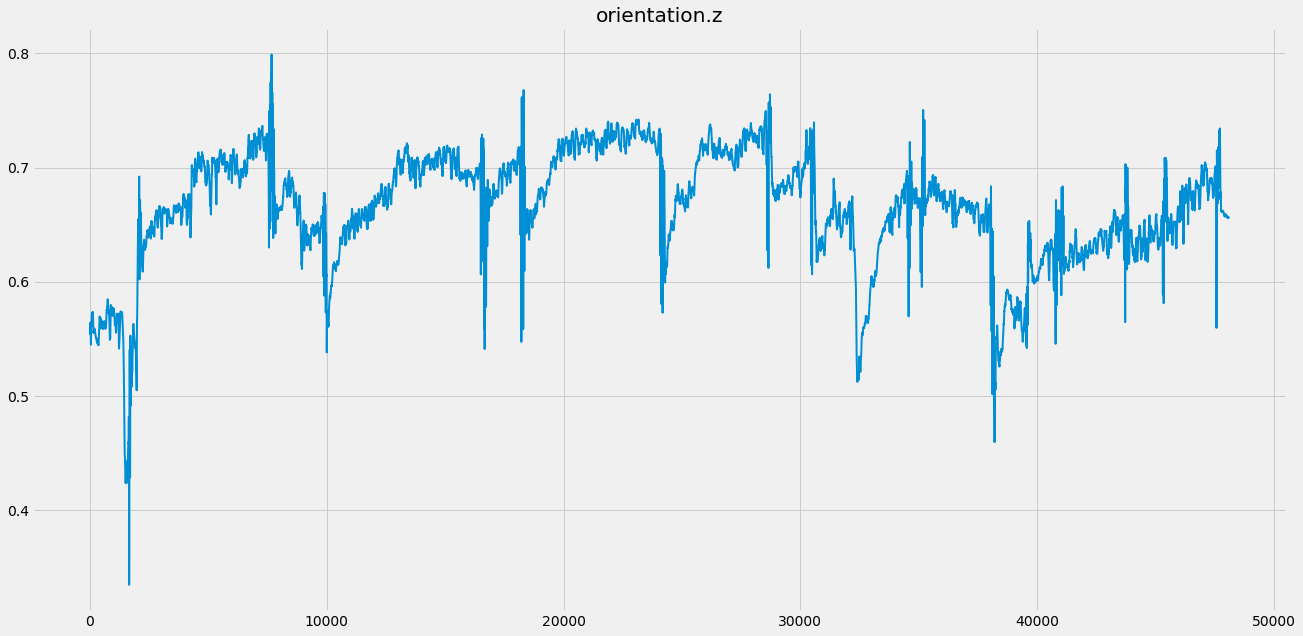

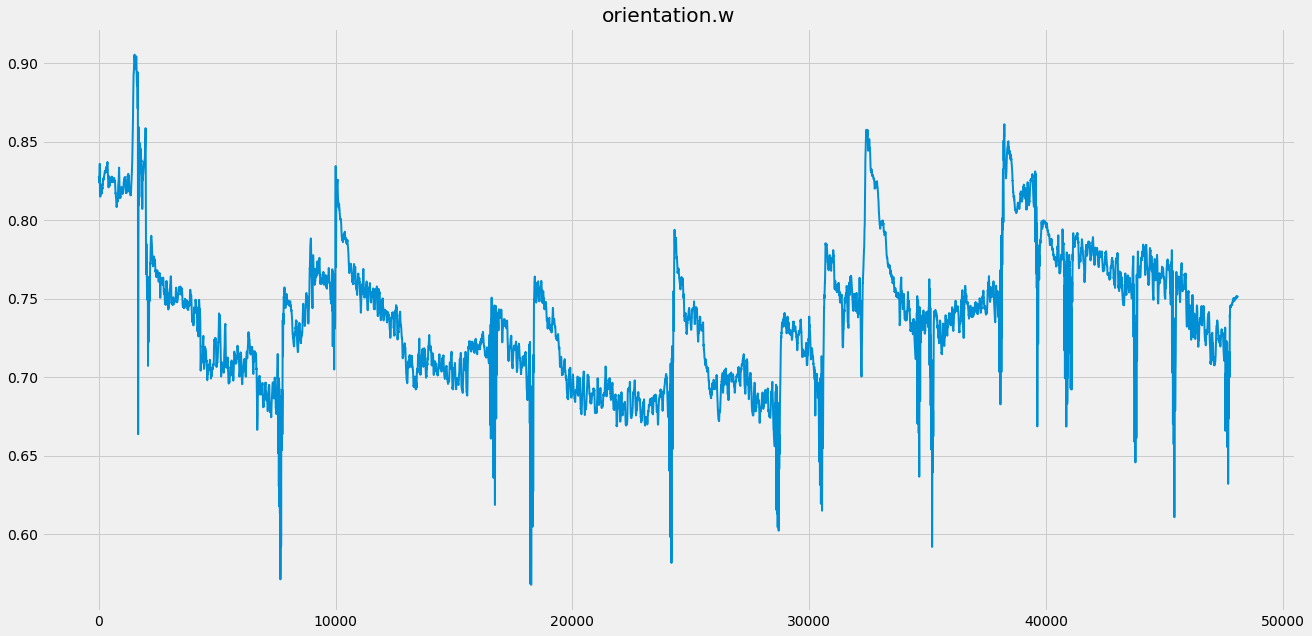

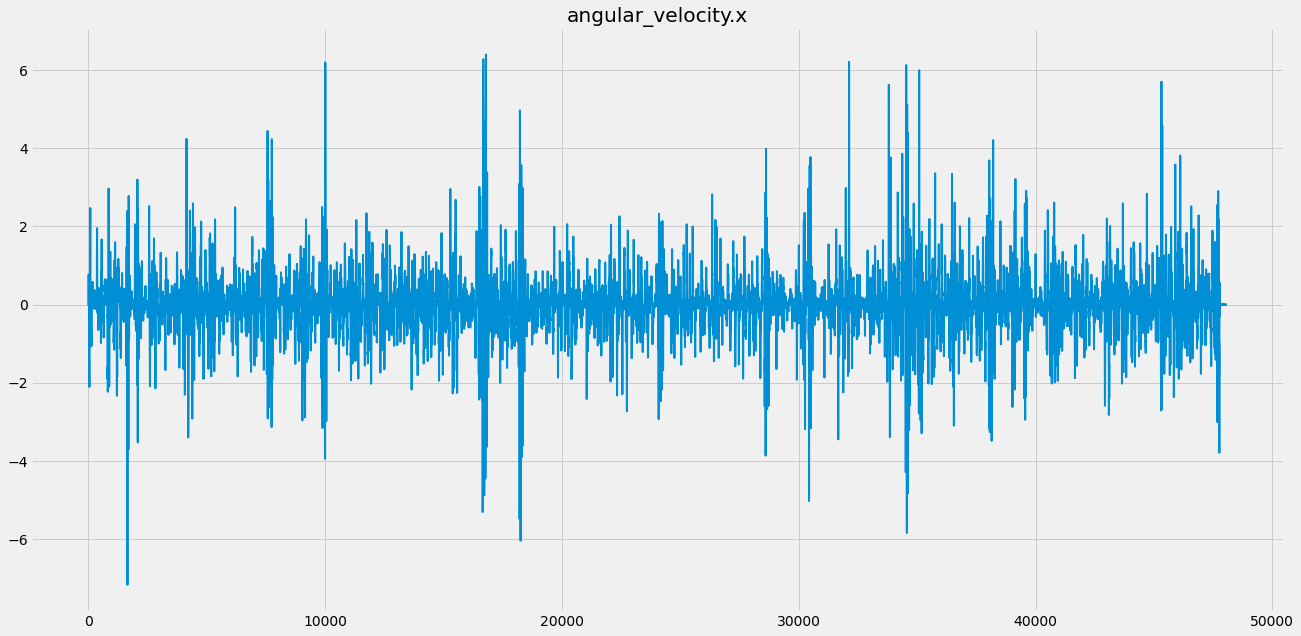

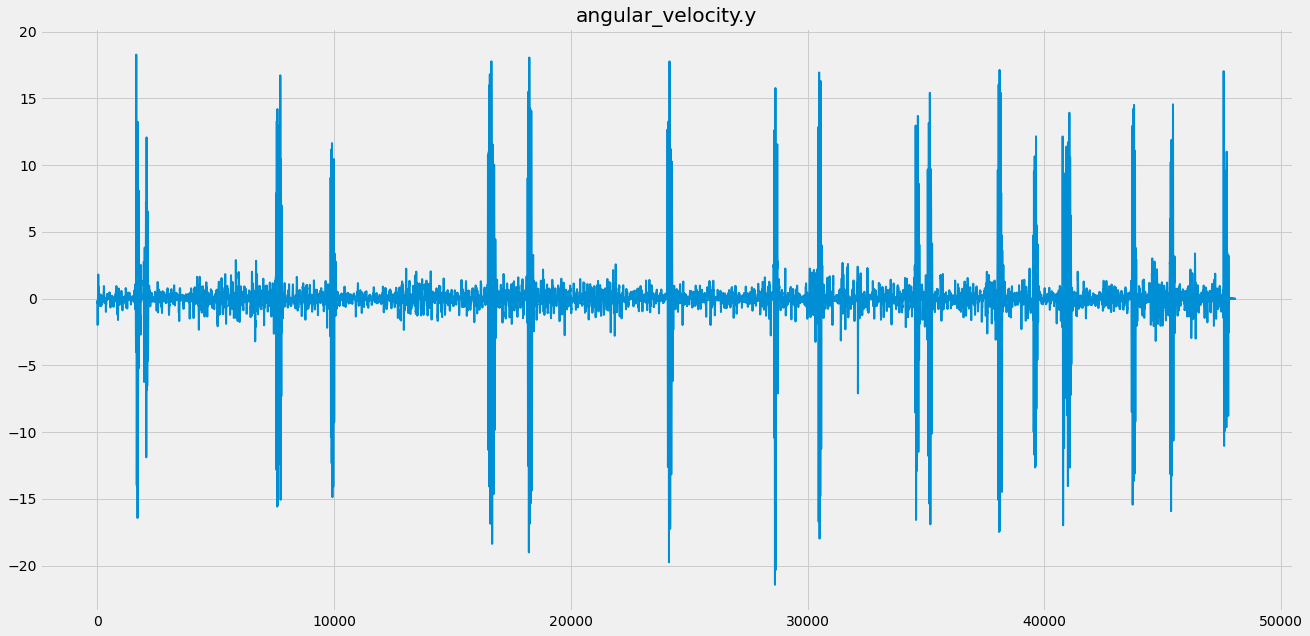

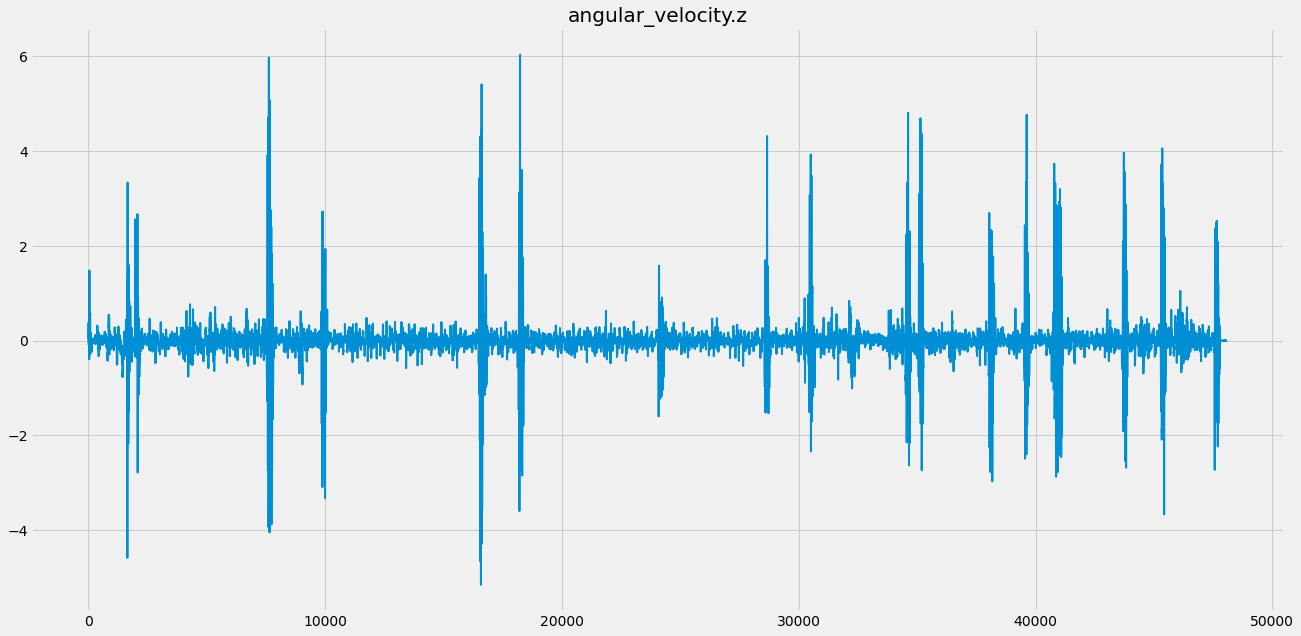

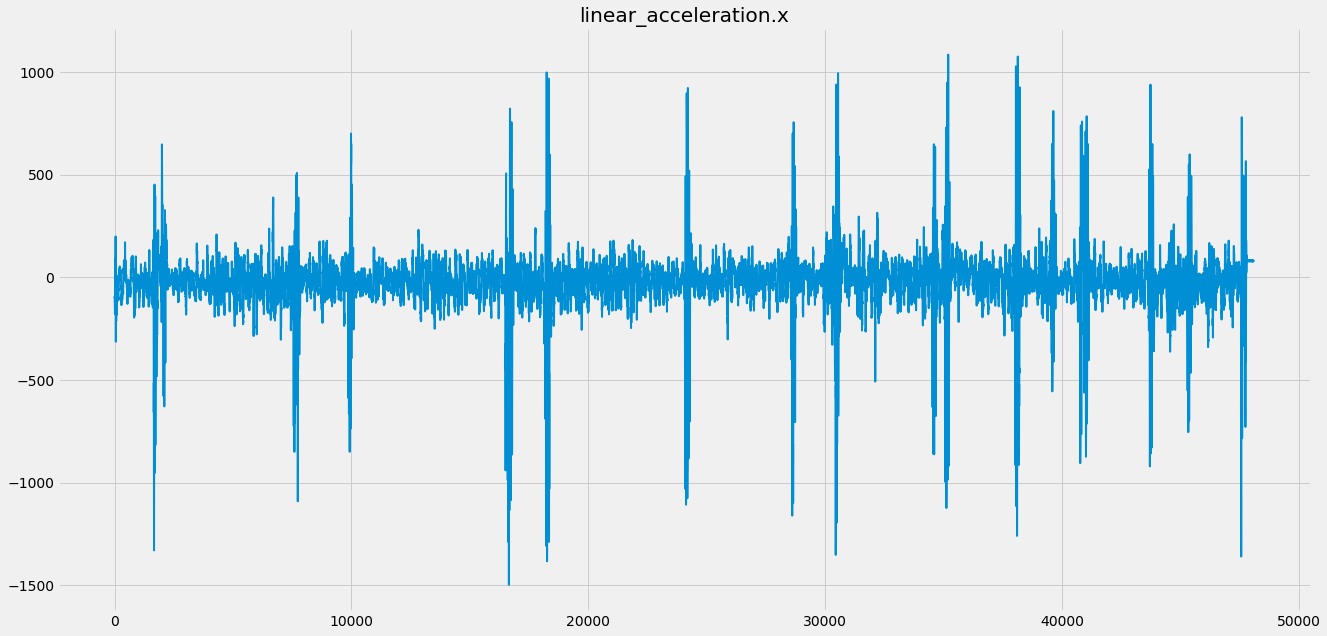

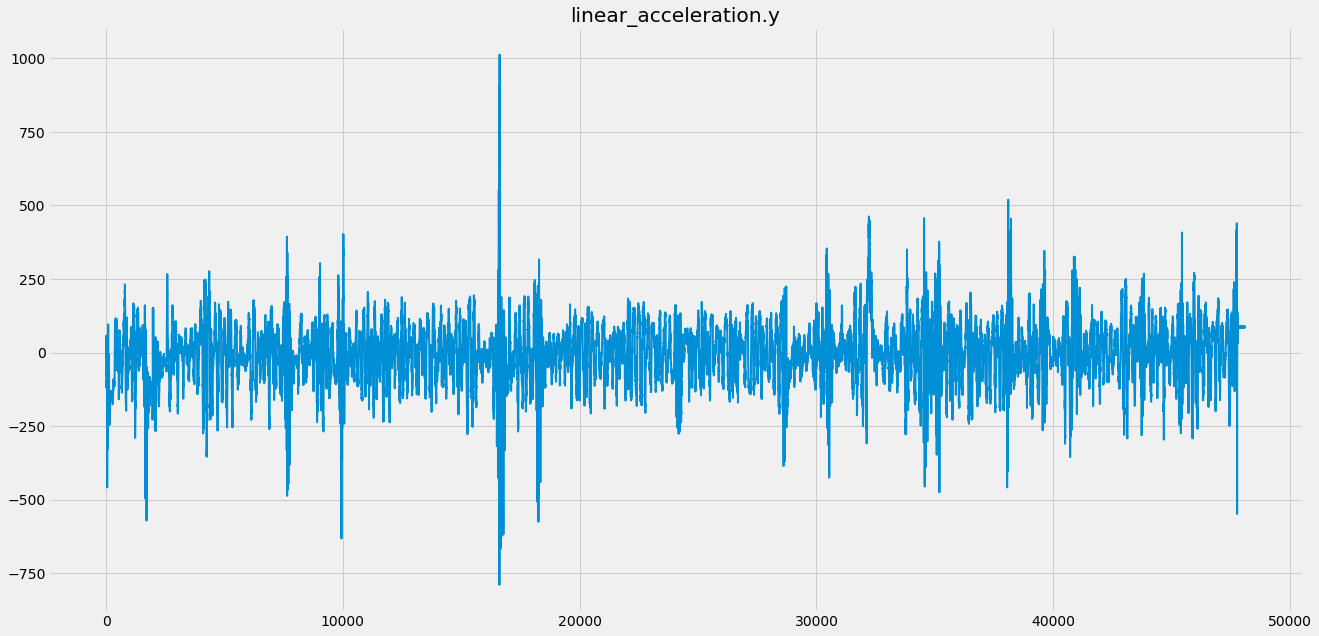

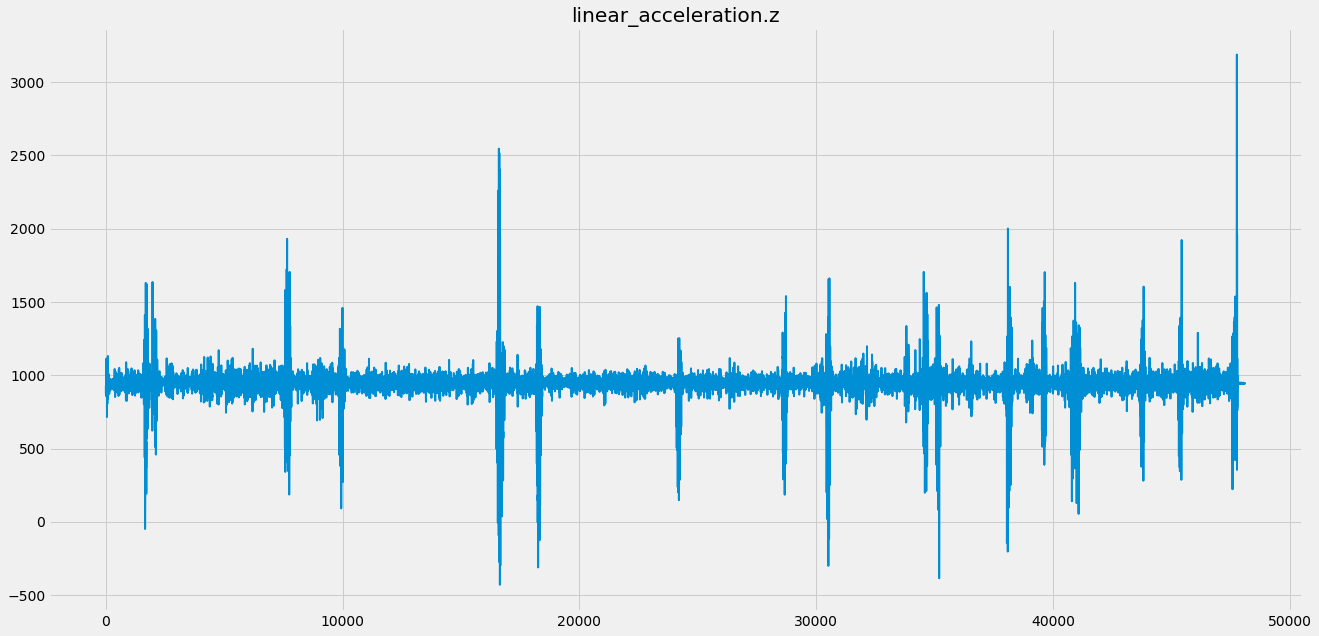

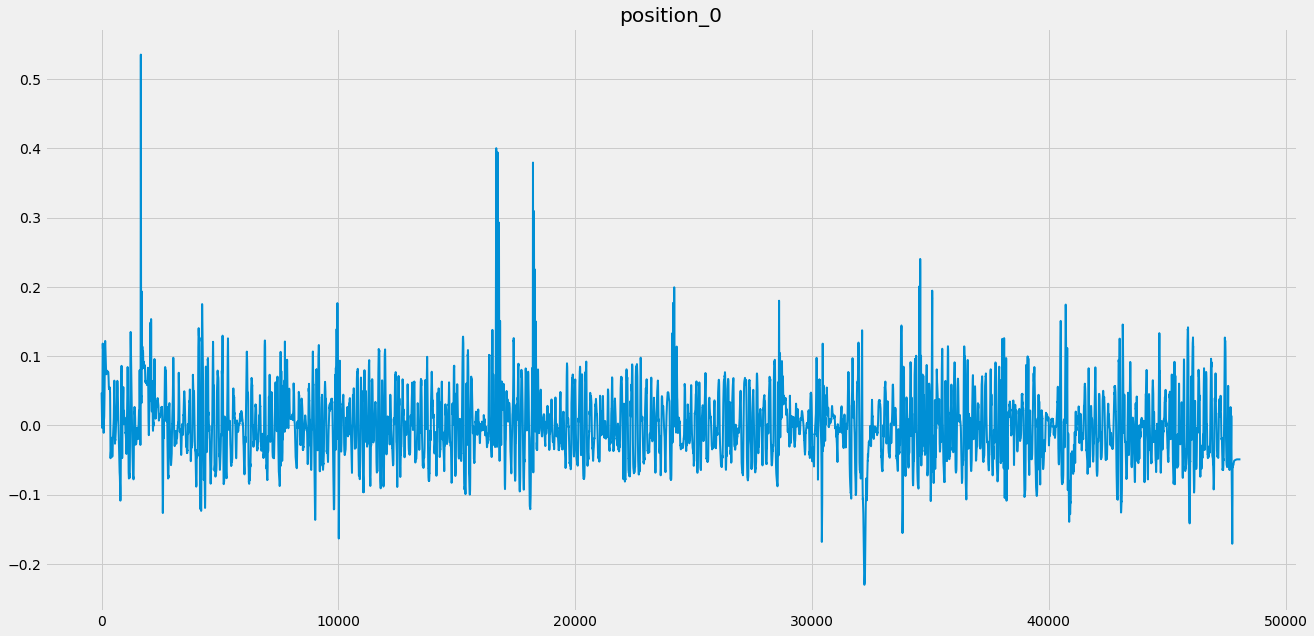

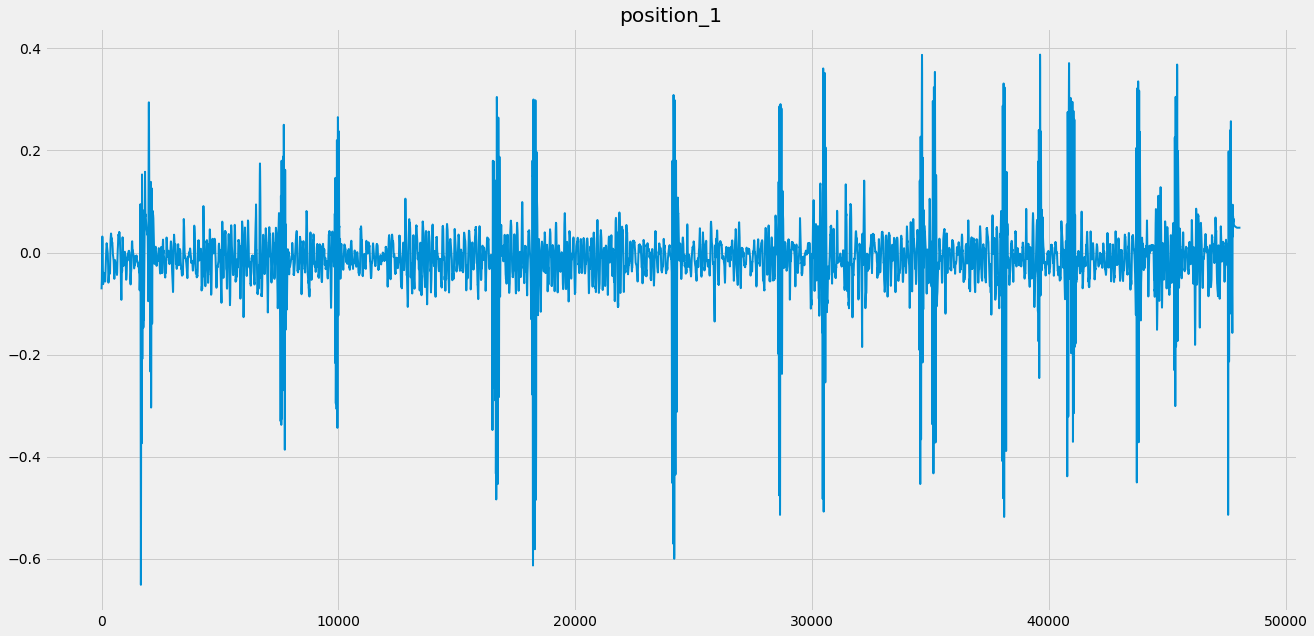

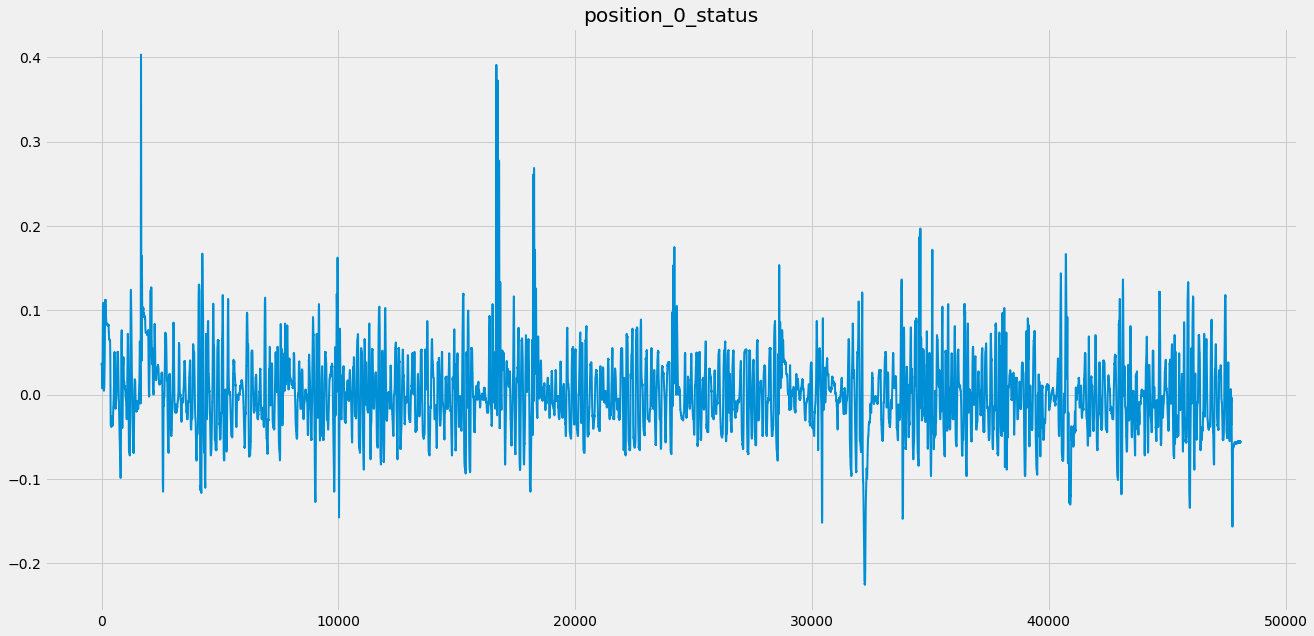

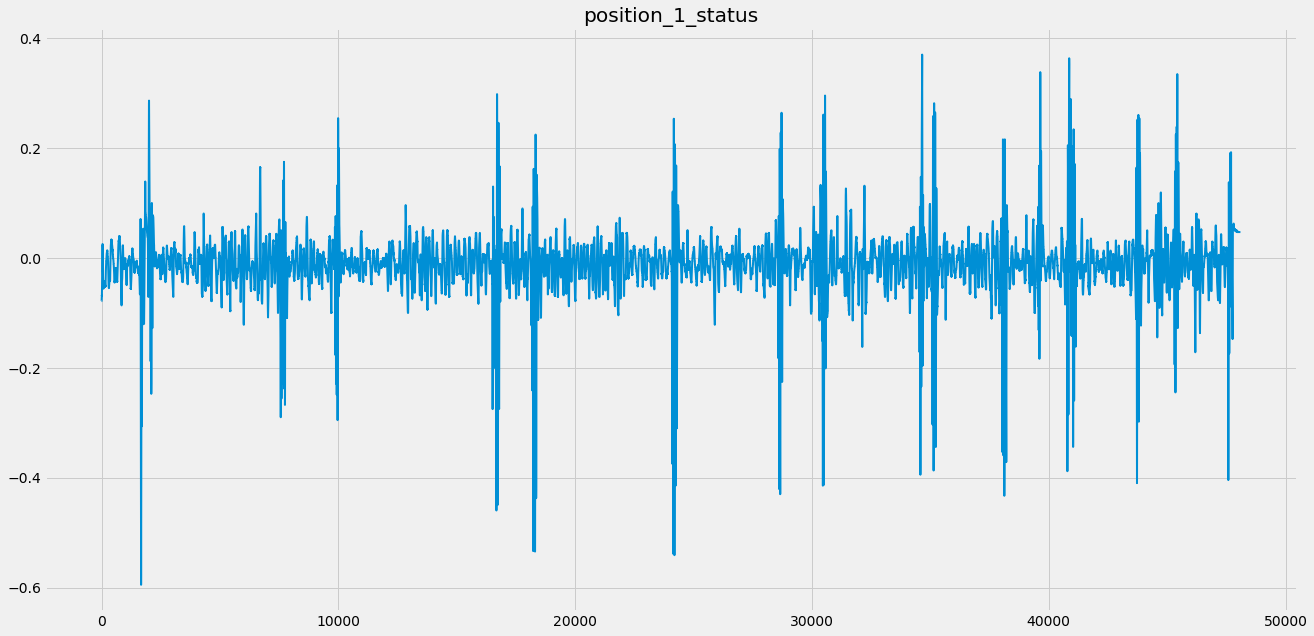

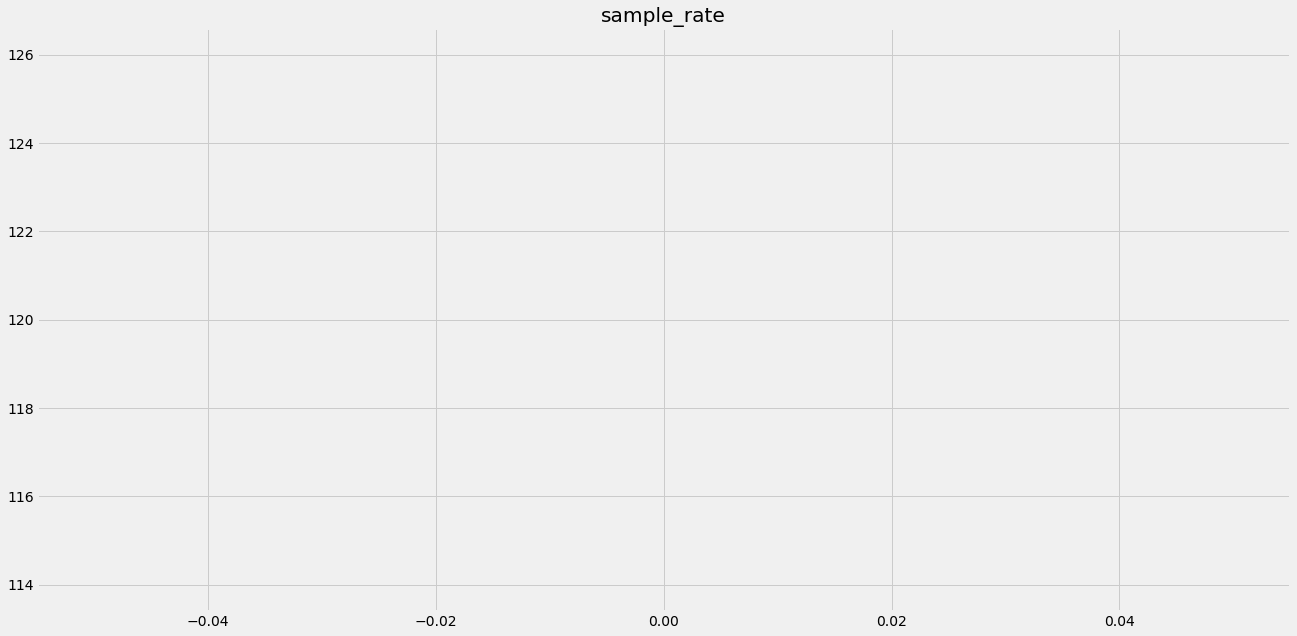

In [13]:
# Sanity check all parameters
for k in e.keys():
    plt.figure()
    plt.plot(e[k], linewidth=2)
    plt.title(k)
print(e['sample_rate'])